# VAE Autoencoder

In [1]:
import numpy as np
import tensorflow as tf
import keras
import Image_finder
import os
import cv2
import sklearn
from matplotlib import pyplot as plt
import shutil
import pickle

proj_loc = os.path.join(os.getcwd(),"faces_resized\\")

Using TensorFlow backend.


The repository of face images consists of 25,489 200x200x3 face images

In [2]:
#loading facescrub images
img_list = np.load('facescrub.npy')

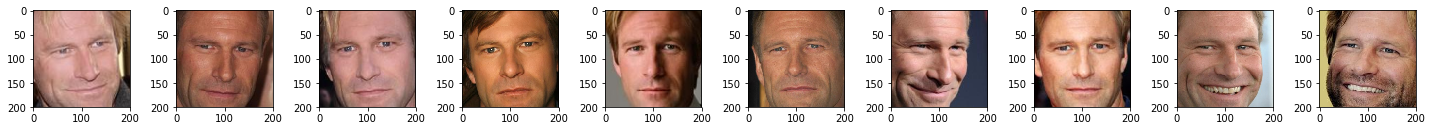

In [23]:
# Plot some of the images to see what's they look like
n=10
fig, axes = plt.subplots(1,n,figsize=(2*n,5))

counter = 0
for i in range(n):
    axes[i].imshow(img_list[counter])
    counter+=1

fig.tight_layout()
plt.savefig('./facesrub_imgs.png')
plt.show()


In [4]:
img_list.shape

(25489, 200, 200, 3)

Writing a function to generate batches of data to allow for more robust training, before defining my graph and running the code.

In [5]:
def mini_batches(data,batch_size,shuffle=False):
    
    assert type(data) is np.ndarray
    assert 0<batch_size<=data.shape[0]
    
    if shuffle:
        data = sklearn.utils.shuffle(data)
        # wierd issue where using numpy.random.shuffle causes all arrays to be shuffled
        #np.random.shuffle(data)
        
    for i in range(0,data.shape[0],batch_size):
        batch = data[i:i+batch_size]
        yield batch
        

In [6]:
def delete_files(folder): 
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

In [7]:
def img_con(img):
    return (img*255).astype('uint8')[:,:,::-1]

In [8]:
act = tf.nn.leaky_relu
#act = tf.nn.sigmoid
def encoder(x,latent_dim=2,activation=tf.nn.elu):
    ''' Takes an input image and encodes it into a 2D latent vector. '''
    x = tf.layers.conv2d(inputs=x, filters=3, kernel_size=(3,3), padding='same', activation=activation)
    x = tf.layers.batch_normalization(x)
    # 200x200x3
    
    x = tf.layers.max_pooling2d(x, pool_size=(2,2), strides=(2,2), padding='same')
    x = tf.layers.batch_normalization(x)
    #100x100x3

    x = tf.layers.conv2d(inputs=x, filters=6, kernel_size=(3,3), padding='same', activation=activation)
    x = tf.layers.batch_normalization(x)
    # 100x100x6
    
    x = tf.layers.max_pooling2d(x, pool_size=(2,2), strides=(2,2), padding='same')
    x = tf.layers.batch_normalization(x)
    # 50x50x6

    FC1 = tf.layers.flatten(x) 
    
    z_mean = tf.layers.dense(FC1,latent_dim, activation=activation)
    z_sigma = tf.layers.dense(FC1,latent_dim, activation=activation)
    
    return z_mean, z_sigma


def decoder(x,activation=act):
    ''' Takes in a 2D vector and produces an image from it. '''
    
    FC4 = tf.layers.dense(x,15000, activation=activation)

    #FC5 = tf.reshape(FC4,shape=[None,50,50,6])
    FC5 = tf.reshape(FC4,shape=tf.convert_to_tensor([-1, 50, 50, 6])) 
    FC5 = tf.layers.batch_normalization(FC5)
     
    x = tf.image.resize_images(FC5, size=(100,100), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    x = tf.layers.batch_normalization(x)
    #100x100x6

    x = tf.layers.conv2d(inputs=x, filters=6, kernel_size=(3,3), padding='same', activation=activation)
    x = tf.layers.batch_normalization(x)
    #100x100x6

    x = tf.image.resize_images(x, size=(200,200), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    x = tf.layers.batch_normalization(x)
    #200x200x6
    
    x = tf.layers.conv2d(inputs=x, filters=3, kernel_size=(3,3), padding='same', activation=activation)
    output = tf.layers.batch_normalization(x)
    #200x200x3
    
    return tf.nn.sigmoid(output)

In [9]:
input_img = tf.placeholder(tf.float32, shape=(None, 200, 200, 3))

z_mean, z_log_sigma = encoder(input_img)

epsilon = tf.random_normal(tf.shape(z_log_sigma), dtype=tf.float32, mean=0.0, stddev=1.0, name='epsilon')
z = z_mean + tf.exp(z_log_sigma/2)*epsilon

decoded = decoder(z)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.


In [10]:
# Define VAE Loss
def vae_loss(x_true,x_recon):
    
    # Reconstruction loss
    recon = 100*tf.reduce_sum(tf.losses.mean_squared_error(labels=input_img,predictions=decoded))
    
    # KL divergence loss
    kl = 0.5 * tf.reduce_sum(tf.exp(z_log_sigma) + tf.square(z_mean) - 1.0 - z_log_sigma)
    
    loss = recon + 0.001*kl
    
    return loss, recon, 0.001*kl

Epoch:0 Iter:10 Loss:6.454, Recon:6.298, kl:0.155
Epoch:0 Iter:20 Loss:6.016, Recon:5.901, kl:0.120
Epoch:0 Iter:30 Loss:6.026, Recon:5.930, kl:0.093
Epoch:0 Iter:40 Loss:5.186, Recon:5.070, kl:0.103
Epoch:0 Iter:50 Loss:5.329, Recon:5.250, kl:0.080
Epoch:0 Iter:60 Loss:5.420, Recon:5.290, kl:0.103
Epoch:0 Iter:70 Loss:5.279, Recon:5.181, kl:0.100
Epoch:0 Iter:80 Loss:5.034, Recon:4.909, kl:0.114
Epoch:0 Iter:90 Loss:4.587, Recon:4.485, kl:0.109
Epoch:0 Iter:100 Loss:4.698, Recon:4.582, kl:0.126
Epoch:0 Iter:110 Loss:4.366, Recon:4.260, kl:0.128
Epoch:0 Iter:120 Loss:4.412, Recon:4.284, kl:0.162
Epoch:0 Iter:130 Loss:4.176, Recon:4.049, kl:0.159
Epoch:0 Iter:140 Loss:4.071, Recon:3.873, kl:0.157
Epoch:0 Iter:150 Loss:4.192, Recon:4.060, kl:0.184
Epoch:0 Iter:160 Loss:4.089, Recon:3.936, kl:0.179
Epoch:0 Iter:170 Loss:4.146, Recon:3.941, kl:0.197
Epoch:0 Iter:180 Loss:3.941, Recon:3.685, kl:0.176
Epoch:0 Iter:190 Loss:3.666, Recon:3.455, kl:0.203
Epoch:0 Iter:200 Loss:3.656, Recon:3.701

Epoch:8 Iter:1610 Loss:3.807, Recon:3.527, kl:0.219
Epoch:8 Iter:1620 Loss:3.718, Recon:3.506, kl:0.240
Epoch:8 Iter:1630 Loss:3.639, Recon:3.371, kl:0.253
Epoch:8 Iter:1640 Loss:3.594, Recon:3.364, kl:0.256
Epoch:8 Iter:1650 Loss:3.685, Recon:3.301, kl:0.288
Epoch:8 Iter:1660 Loss:3.874, Recon:3.687, kl:0.243
Epoch:8 Iter:1670 Loss:3.657, Recon:3.324, kl:0.268
Epoch:8 Iter:1680 Loss:3.793, Recon:3.584, kl:0.244
Epoch:8 Iter:1690 Loss:3.640, Recon:3.339, kl:0.271
Epoch:8 Iter:1700 Loss:3.765, Recon:3.601, kl:0.251
Epoch:8 Iter:1710 Loss:3.537, Recon:3.306, kl:0.266
Epoch:8 Iter:1720 Loss:3.737, Recon:3.523, kl:0.263
Epoch:8 Iter:1730 Loss:3.922, Recon:3.728, kl:0.234
Epoch:8 Iter:1740 Loss:3.724, Recon:3.509, kl:0.241
Epoch:8 Iter:1750 Loss:3.344, Recon:3.096, kl:0.226
Epoch:8 Iter:1760 Loss:3.552, Recon:3.313, kl:0.242
Epoch:8 Iter:1770 Loss:3.882, Recon:3.632, kl:0.236
Epoch:8 Iter:1780 Loss:3.781, Recon:3.521, kl:0.262
Epoch:8 Iter:1790 Loss:3.841, Recon:3.614, kl:0.261
Epoch:8 Iter

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

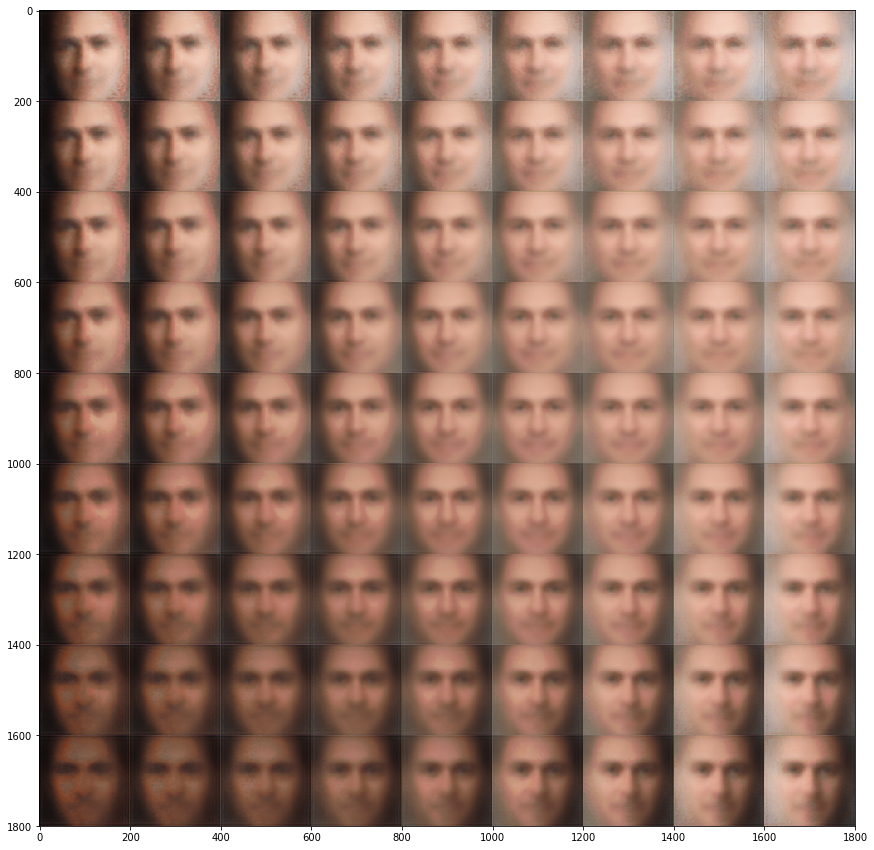

In [16]:
# Declare input
learning_rate = 0.001
n_epochs = 10
batch_size = 128

loss, recon, kl = vae_loss(input_img,decoded)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

img_list_train = img_list 
delete_files('.//outputs//')
#Delete all files in loc
delete_files('.//outputs_latent_space//')

init = tf.global_variables_initializer()

LOSS= list()
output_list = list()
with tf.Session() as sess:
    init.run()
    
    iteration = 0
    for epoch in range(n_epochs):
        
        for batch in mini_batches(data=img_list_train,batch_size=batch_size,shuffle=True):

            sess.run(training_op, feed_dict={input_img:batch})
            loss_ = loss.eval(feed_dict={input_img:batch})
            LOSS.append(loss_)
   
            iteration+=1
            
            #dec = decoded.eval(feed_dict={input_img:img_list_train})
            '''
            if iteration%5==0:
                cv2.imwrite('./outputs/temp_VAE_{}.png'.format(iteration),
                            img_con(decoded.eval(feed_dict={input_img:img_list_train[339:340]}))[:,:,::-1][-1])
            '''
            
            if iteration%10==0:
                print("Epoch:{} Iter:{} Loss:{:0.3f}, Recon:{:0.3f}, kl:{:0.3f}".format(epoch,iteration, loss_,
                                                                               recon.eval(feed_dict={input_img:batch}),
                                                                               kl.eval(feed_dict={input_img:batch})))
    
            # Generate some images using a grid space
            if iteration%5==0:
                n = 9
                digit_size = 200
                epsilon_std = 3.0

                figure = np.zeros((digit_size * n, digit_size * n,3))
                grid_x = np.linspace(-1.0, 1.0, n)
                grid_y = np.linspace(-1.0, 1.0, n)

                for i, yi in enumerate(grid_x):
                    for j, xi in enumerate(grid_y):
                        z_sample = np.array([[xi, yi]]) * epsilon_std
                        gen_img = decoded.eval(feed_dict={z:z_sample})

                        digit = gen_img[0]

                        figure[i * digit_size: (i + 1) * digit_size,
                               j * digit_size: (j + 1) * digit_size] = digit
                plt.figure(figsize=(15, 15))
                plt.imshow(figure)
                plt.savefig('./outputs_latent_space/temp_VAE_{}.png'.format(iteration)) 
                
                # Clearing figure to prevent running out of memory
                plt.clf()
                
    n = 9
    digit_size = 200
    epsilon_std = 3.0

    figure = np.zeros((digit_size * n, digit_size * n,3))
    grid_x = np.linspace(-1.0, 1.0, n)
    grid_y = np.linspace(-1.0, 1.0, n)

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]]) * epsilon_std
            gen_img = decoded.eval(feed_dict={z:z_sample})

            digit = gen_img[0]

            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(15, 15))
    plt.imshow(figure)
    plt.show()

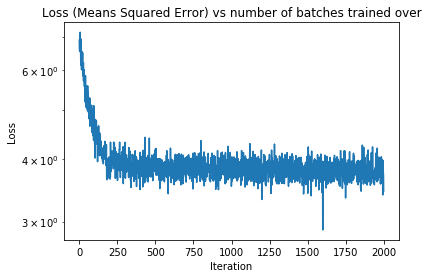

In [17]:
plt.plot(LOSS)
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss (Means Squared Error) vs number of batches trained over")
plt.show()

In [18]:
import imageio
import glob
import re

# open up images and put an eopch number in the top corner
for n, filename in enumerate(glob.glob('./outputs_latent_space/*.png')):
    num = re.findall(r'\d+', filename)[0]
    
    image = cv2.imread(filename)
    texted_image =cv2.putText(img=np.copy(image), text="Iter: {}".format(num), 
                              org=(10,20),fontFace=1, fontScale=1, color=(0,0,0), thickness=1)
    cv2.imwrite('./outputs_latent_space/temp_VAE_{}.png'.format(num),texted_image)

In [21]:
with imageio.get_writer('Facescrub_latents_space.gif', mode='I') as writer:
    filenames = glob.glob('./outputs_latent_space/*.png')
    my_tuple = sorted(tuple(zip([int(re.findall(r'\d+', x)[0]) for x in filenames],filenames)))
    last = -1
    filenames = [x[1] for x in my_tuple]
    for i,filename in enumerate(filenames):
        frame = 2*(i**1.0)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
#os.system('CNN_VAE2.gif')